In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, DepthwiseConv2D, Activation,
    AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D,
    Reshape, Multiply, SeparableConv2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [10]:
BASE_PATH_CROSS = '/content/drive/MyDrive/Final Project data/Cross'
BASE_PATH_INTRA = '/content/drive/MyDrive/Final Project data/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 200
STEP = 50

In [25]:
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No files found in {directory}")
    return files
def load_data(file_paths):
    data, labels = [], []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename: task = 'rest'
        elif 'motor' in filename: task = 'task_motor'
        elif 'story' in filename or 'math' in filename: task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename: task = 'task_working_memory'
        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)
def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start, end = j * step, j * step + window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)
def normalize_data(data):
    n_samples, n_channels, n_timesteps = data.shape
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(reshaped_data)
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)
def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    augmented_data, augmented_labels = list(data), list(labels)
    for i in range(len(data)):
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=data[i].shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_data.append((data[i] + noise) * scaler)
        augmented_labels.append(labels[i])
    return np.array(augmented_data), np.array(augmented_labels)
def preprocess_pipeline(base_dir, window_size, step, is_training=True):
    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]
    X_win, y_win = windowing(X_ds, y, window_size, step)
    X_norm = normalize_data(X_win)
    if is_training:
        final_X, final_y = augment_data(X_norm, y_win)
    else:
        final_X, final_y = X_norm, y_win
    final_X = final_X[..., np.newaxis]
    print(f"Final shape: {final_X.shape}")
    return final_X, final_y

In [7]:
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1 if tf.keras.backend.image_data_format() == "channels_last" else 1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([init, se])
    return x
def EEGNet_with_Attention_Regularized(nb_classes, Chans, Samples, dropoutRate, kernLength, F1, D, F2, l2_lambda):
    input1 = Input(shape=(Chans, Samples, 1))
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)
    block1_attention = squeeze_excite_block(block1)
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='valid', depthwise_regularizer=l2(l2_lambda), pointwise_regularizer=l2(l2_lambda))(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25), kernel_regularizer=l2(l2_lambda))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)
    return Model(inputs=input1, outputs=softmax)


In [13]:
hyperparameter_grid = [
    {"trial_id": "Original_Best", "learning_rate": 0.001, "dropoutRate": 0.6, "l2_lambda": 0.001, "F1": 8},
    {"trial_id": "Lower_LR_Higher_Reg", "learning_rate": 0.0005, "dropoutRate": 0.6, "l2_lambda": 0.01, "F1": 8},
    {"trial_id": "Higher_Dropout", "learning_rate": 0.001, "dropoutRate": 0.7, "l2_lambda": 0.001, "F1": 8},
    {"trial_id": "More_Filters", "learning_rate": 0.001, "dropoutRate": 0.6, "l2_lambda": 0.001, "F1": 16},
]

try:
    X_train_cross, y_train_cross = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, window_size=WINDOW_SIZE)
    X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, is_training=False, window_size=WINDOW_SIZE)
    X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, is_training=False, window_size=WINDOW_SIZE)
    X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, is_training=False, window_size=WINDOW_SIZE)
    X_train_intra, y_train_intra = preprocess_pipeline(INTRA_TRAIN_DIR, is_training=True, window_size=WINDOW_SIZE)
    X_test_intra, y_test_intra = preprocess_pipeline(INTRA_TEST_DIR, is_training=False, window_size=WINDOW_SIZE)

    results_log = []

    for i, params in enumerate(hyperparameter_grid):
        print("\n" + "="*80)
        print(f"###   STARTING trial {i+1}/{len(hyperparameter_grid)}: {params['trial_id']}   ###")
        print(f"Parameters: {params}")
        print("="*80)

        print("\n Training for cross-subject generalization")
        tf.keras.backend.clear_session()
        model_cross = EEGNet_with_Attention_Regularized(
            nb_classes=len(TASKS), Chans=N_CHANNELS, Samples=WINDOW_SIZE,
            dropoutRate=params['dropoutRate'], l2_lambda=params['l2_lambda'], F1=params['F1'],
            D=2, F2=params['F1'] * 2, kernLength=64
        )
        optimizer = Adam(learning_rate=params['learning_rate'])
        model_cross.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        callbacks_cross = [
            EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        ]
        model_cross.fit(
            X_train_cross, y_train_cross, batch_size=32, epochs=100,
            validation_split=0.2, callbacks=callbacks_cross, verbose=0 # verbose=0 to keep log clean
        )

        print("\n evaluating cross-subject model ")
        loss1, acc1 = model_cross.evaluate(X_test1, y_test1, verbose=0)
        loss2, acc2 = model_cross.evaluate(X_test2, y_test2, verbose=0)
        loss3, acc3 = model_cross.evaluate(X_test3, y_test3, verbose=0)
        avg_cross_accuracy = np.mean([acc1, acc2, acc3])
        print(f"Average Cross accuracy: {avg_cross_accuracy:.4f}")

        print("\n training for Intra-subject personalizatiion")
        tf.keras.backend.clear_session()
        model_intra = EEGNet_with_Attention_Regularized(
            nb_classes=len(TASKS), Chans=N_CHANNELS, Samples=WINDOW_SIZE,
            dropoutRate=params['dropoutRate'], l2_lambda=params['l2_lambda'], F1=params['F1'],
            D=2, F2=params['F1'] * 2, kernLength=64
        )
        optimizer_intra = Adam(learning_rate=params['learning_rate'])
        model_intra.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_intra, metrics=['accuracy'])

        callbacks_intra = [
            EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        ]
        model_intra.fit(
            X_train_intra, y_train_intra, batch_size=16, epochs=100,
            validation_split=0.2, callbacks=callbacks_intra, verbose=0
        )

        print("\n evaluating intra model ---")
        loss_intra, acc_intra = model_intra.evaluate(X_test_intra, y_test_intra, verbose=0)
        print(f"intra subject test accuracy: {acc_intra:.4f}")

        trial_results = params.copy()
        trial_results['avg_cross_accuracy'] = avg_cross_accuracy
        trial_results['intra_accuracy'] = acc_intra
        results_log.append(trial_results)

    print("\n\n" + "#"*80)
    print("###                       FINAL EXPERIMENT RESULTS                       ###")
    print("#"*80 + "\n")

    results_df = pd.DataFrame(results_log)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    print("--- Results sorted by Cross-Subject Accuracy ---")
    print(results_df.sort_values(by='avg_cross_accuracy', ascending=False))

    print("\n\n--- Results sorted by Intra-Subject Accuracy ---")
    print(results_df.sort_values(by='intra_accuracy', ascending=False))

except FileNotFoundError as e:
    print(f"\nERROR: A file or directory was not found. Please check paths.")
    print(e)
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Cross/train/ ---
Final shape: (8704, 248, 200, 1)

--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Cross/test1/ ---
Final shape: (1088, 248, 200, 1)

--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Cross/test2/ ---
Final shape: (1088, 248, 200, 1)

--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Cross/test3/ ---
Final shape: (1088, 248, 200, 1)

--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Intra/train/ ---
Final shape: (4352, 248, 200, 1)

--- Preprocessing data from: /content/drive/MyDrive/Final Project data/Intra/test/ ---
Final shape: (544, 248, 200, 1)

###   STARTING TRIAL 1/4: Original_Best   ###
Parameters: {'trial_id': 'Original_Best', 'learning_rate': 0.001, 'dropoutRate': 0.6, 'l2_lambda': 0.001, 'F1': 8}

--- Training for Cross-Subject Generalization ---
Epoch 65: early stopping
Restoring model weights from the

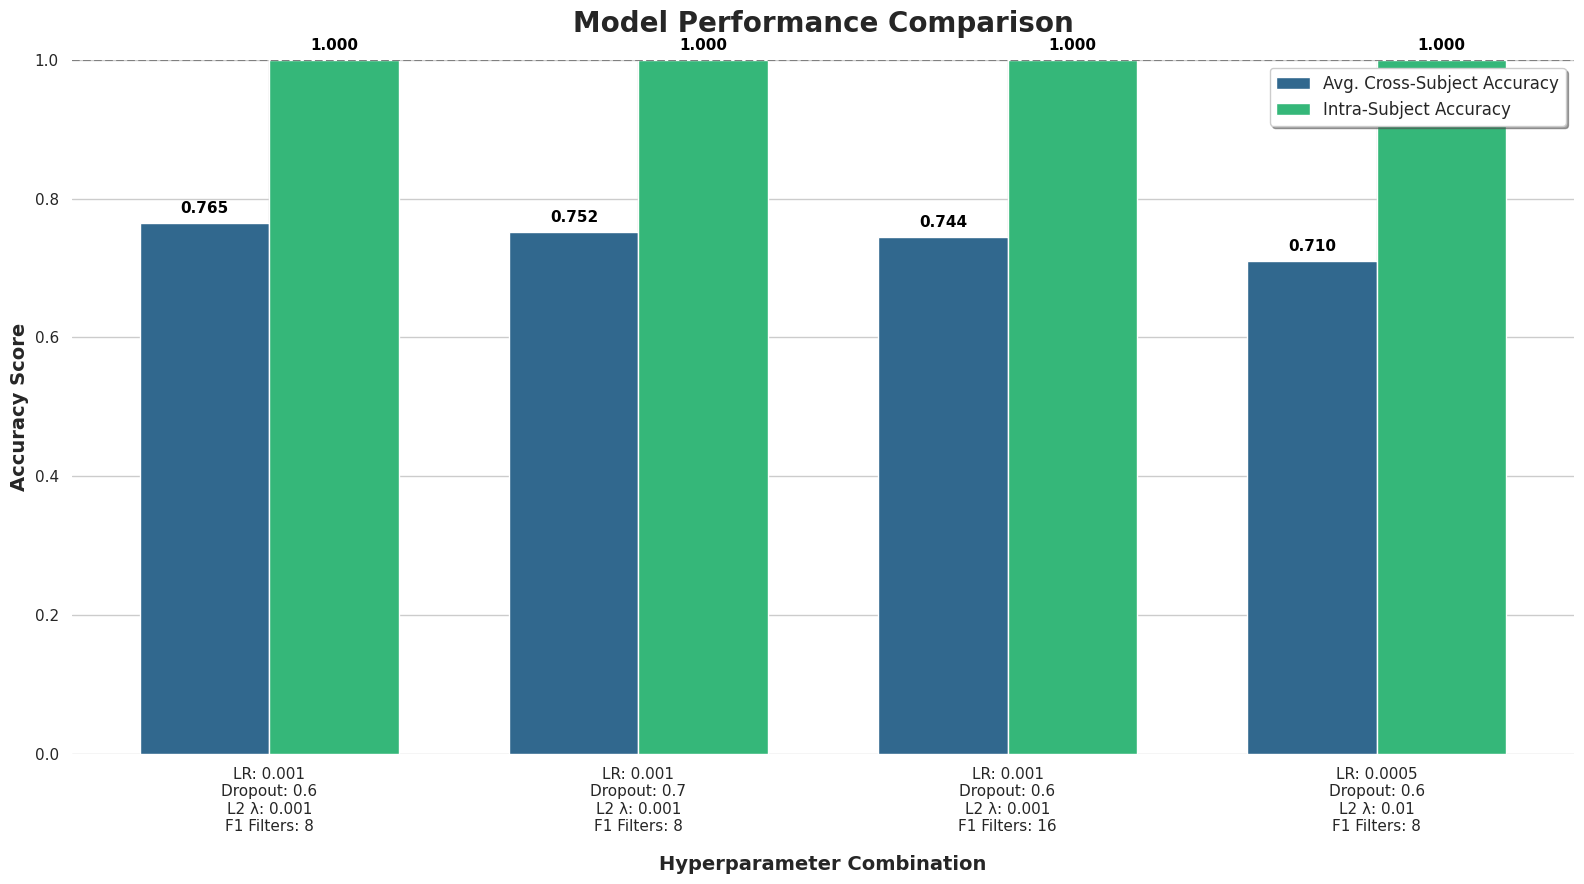

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = {
    'trial_id': ["Original_Best", "Higher_Dropout", "More_Filters", "Lower_LR"],
    'learning_rate': [0.001, 0.001, 0.001, 0.0005],
    'dropoutRate': [0.6, 0.7, 0.6, 0.6],
    'l2_lambda': [0.001, 0.001, 0.001, 0.01],
    'F1': [8, 8, 16, 8],
    'avg_cross_accuracy': [0.765319, 0.751532, 0.744485, 0.709559],
    'intra_accuracy': [1.0, 1.0, 1.0, 1.0]
}
results_df = pd.DataFrame(data)

hyperparameter_labels = []
for index, row in results_df.iterrows():
    label = (
        f"LR: {row['learning_rate']}\n"
        f"Dropout: {row['dropoutRate']}\n"
        f"L2 λ: {row['l2_lambda']}\n"
        f"F1 Filters: {row['F1']}"
    )
    hyperparameter_labels.append(label)


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(len(hyperparameter_labels))
width = 0.35
cross_acc = results_df['avg_cross_accuracy']
intra_acc = results_df['intra_accuracy']

colors = sns.color_palette("viridis", 2)

rects1 = ax.bar(x - width/2, cross_acc, width, label='Avg. Cross Accuracy', color=colors[0])
rects2 = ax.bar(x + width/2, intra_acc, width, label='Intra Accuracy', color=colors[1])

ax.set_ylabel('Accuracy Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Hyperparameter Combination', fontsize=14, fontweight='bold', labelpad=15)
ax.set_title('Model Performance Comparison', fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(hyperparameter_labels, fontsize=11) # Use the new detailed labels
ax.legend(fontsize=12, frameon=True, shadow=True, loc='upper right')

ax.set_ylim(0, 1)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, label='Perfect Score')

def autolabel(rects, color='black'):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontweight='bold',
                    fontsize=11,
                    color=color)
autolabel(rects1)
autolabel(rects2)
sns.despine(left=True, bottom=True)
fig.tight_layout()
plt.show()

In [27]:
window_sizes_to_test = [100, 150, 200, 250]
step_size = 50

try:
    results_log = []

    for i, window_size in enumerate(window_sizes_to_test):
         # Calculate step size
        print("\n" + "="*80)
        print(f"    STARTING experiment {i+1}/{len(window_sizes_to_test)}: WINDOW_SIZE = {window_size}, STEP = {step_size}  ")
        print("="*80)

        X_train, y_train = preprocess_pipeline(CROSS_TRAIN_DIR, window_size=window_size, step=step_size, is_training=True)
        X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, window_size=window_size, step=step_size, is_training=False)
        X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, window_size=window_size, step=step_size, is_training=False)
        X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, window_size=window_size, step=step_size, is_training=False)

        tf.keras.backend.clear_session()

        model = EEGNet_with_Attention_Regularized(
            nb_classes=len(TASKS),
            Chans=N_CHANNELS,
            Samples=window_size,
            dropoutRate=0.6,
            l2_lambda=0.001,
            F1=8,
            D=2,
            F2=16,
            kernLength=64
        )

        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        ]

        model.fit(
            X_train, y_train, batch_size=32, epochs=100,
            validation_split=0.2, callbacks=callbacks, verbose=0
        )

        print(f"\n  evaluating for window size: {window_size}   ")
        loss1, acc1 = model.evaluate(X_test1, y_test1, verbose=0)
        loss2, acc2 = model.evaluate(X_test2, y_test2, verbose=0)
        loss3, acc3 = model.evaluate(X_test3, y_test3, verbose=0)
        average_accuracy = np.mean([acc1, acc2, acc3])
        print(f"  avg Cross Accuracy: {average_accuracy:.4f}")

        # Log results
        results_log.append({
            'window_size': window_size,
            'step_size': step_size,
            'average_accuracy': average_accuracy
        })

    print("\n\n" + "#"*60)
    print("WINDOW SIZE EXPERIMENT RESULTSs")
    print("#"*60 + "\n")

    results_df = pd.DataFrame(results_log)
    results_df = results_df.sort_values(by='average_accuracy', ascending=False)

    print(results_df)
    print("\n\n     Best window size    ")
    print(results_df.iloc[0])

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


    STARTING TRIAL 1/4: WINDOW_SIZE = 100, STEP = 50  
Final shape: (8960, 248, 100, 1)
Final shape: (1120, 248, 100, 1)
Final shape: (1120, 248, 100, 1)
Final shape: (1120, 248, 100, 1)
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 47.

  evaluating for window size: 100   
  avg Cross Accuracy: 0.7592

    STARTING TRIAL 2/4: WINDOW_SIZE = 150, STEP = 50  
Final shape: (8832, 248, 150, 1)
Final shape: (1104, 248, 150, 1)
Final shape: (1104, 248, 150, 1)
Final shape: (1104, 248, 150, 1)
Restoring model weights from the end of the best epoch: 97.

  evaluating for window size: 150   
  avg Cross Accuracy: 0.6528

    STARTING TRIAL 3/4: WINDOW_SIZE = 200, STEP = 50  
Final shape: (8704, 248, 200, 1)
Final shape: (1088, 248, 200, 1)
Final shape: (1088, 248, 200, 1)
Final shape: (1088, 248, 200, 1)
Restoring model weights from the end of the best epoch: 99.

  evaluating for window size: 200   
  avg Cross Accuracy: 0.7733

    STARTING TRIAL 4/4: WINDO

<ipython-input-35-2312817222>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


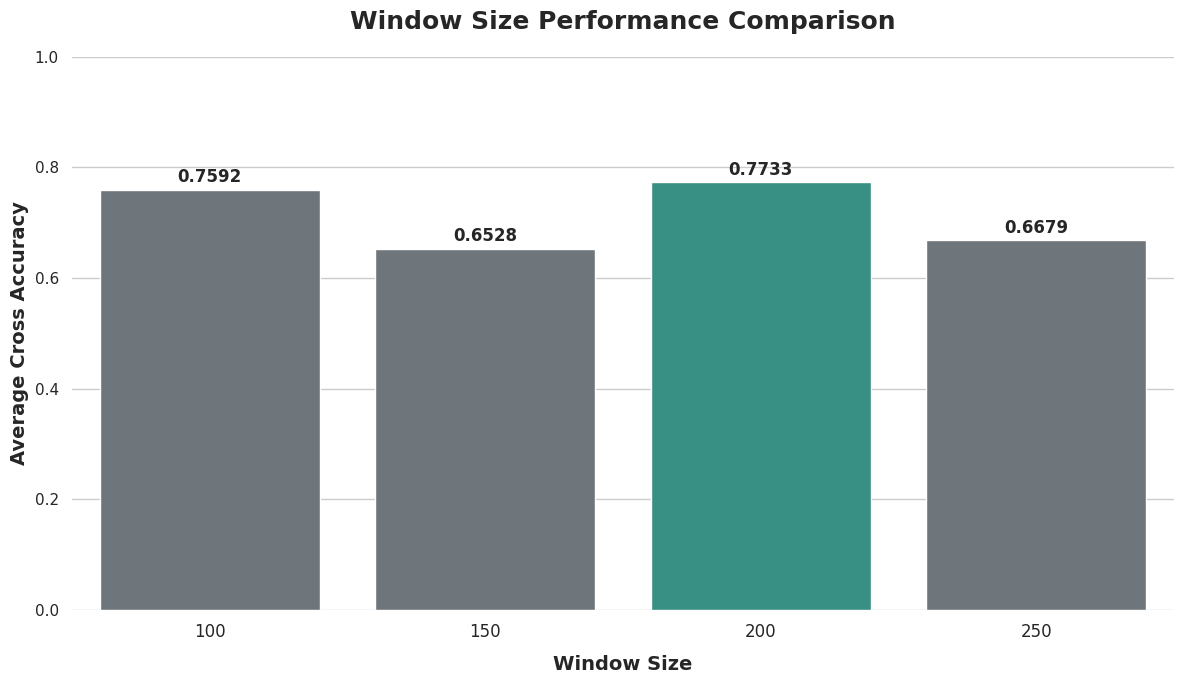

In [35]:
data = {
    'window_size': [200, 100, 250, 150],
    'step_size': [50, 50, 50, 50],
    'average_accuracy': [0.773284, 0.759226, 0.667910, 0.652778]
}
results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by='window_size').reset_index(drop=True)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
highlight_color = '#2a9d8f'
default_color = '#6c757d'
max_acc = results_df['average_accuracy'].max()
bar_colors = [highlight_color if acc == max_acc else default_color for acc in results_df['average_accuracy']]

barplot = sns.barplot(
    x='window_size',
    y='average_accuracy',
    data=results_df,
    palette=bar_colors,
    ax=ax
)

for p in barplot.patches:
    ax.annotate(
        f'{p.get_height():.4f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='bold',
        fontsize=12
    )
ax.set_title('Window Size Performance Comparison', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Window Size', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Average Cross Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
# Check with others if it's better to put between 0 and 1 or other range
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()